### READ CSV FILES

In [0]:
salary_data = "/FileStore/tables/salarydata/salary_data.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# Reading csv file and store them into salary_data fame
salary_data  = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(salary_data)

print(salary_data.columns)

['Case Number', 'Case Number (group) 1', 'Case Received Date', 'Case Status', 'College Major Required', 'Country Of Citizenship', 'Decision Date', 'Education Level Required', 'Employer Name', 'Experience Required Num Months', 'Experience Required Y N', 'Full Time Position Y N', 'Job Title', 'Job Title Subgroup', 'Paid Wage Submitted Unit', 'Prevailing Wage Soc Code', 'Prevailing Wage Soc Title', 'Prevailing Wage Submitted', 'Prevailing Wage Submitted Unit', 'States we are interested in', 'Visa Class', 'Work City', 'Work Postal Code', 'Work State', 'Work State (group)', 'Work State Abbreviation', 'Number of Records', 'Order', 'Paid Wage Per Year', 'PAID_WAGE_SUBMITTED', 'Prevailing Wage Per Year']


In [0]:
print(salary_data.head(1))

[Row(Case Number='I-200-14015-835460', Case Number (group) 1='Other', Case Received Date='1/23/2014', Case Status='certified', College Major Required='NA', Country Of Citizenship='NA', Decision Date='1/30/2014', Education Level Required='NA', Employer Name='MOTOROLA MOBILITY LLC', Experience Required Num Months='NA', Experience Required Y N='NA', Full Time Position Y N='y', Job Title='SOFTWARE ENGINEER', Job Title Subgroup='software engineer', Paid Wage Submitted Unit=None, Prevailing Wage Soc Code='15-1133', Prevailing Wage Soc Title='Software Developers, Systems Software', Prevailing Wage Submitted='77834', Prevailing Wage Submitted Unit='year', States we are interested in="Don't view", Visa Class='H-1B', Work City='CHICAGO', Work Postal Code='NA', Work State='Illinois', Work State (group)='Illinoius', Work State Abbreviation='IL', Number of Records='1', Order='65619', Paid Wage Per Year='77834', PAID_WAGE_SUBMITTED='77834', Prevailing Wage Per Year='77834')]


###DEFINE TABLES

In [0]:
spark.sql("""
   DROP TABLE fact_visa_cases
""")
dbutils.fs.rm("dbfs:/user/hive/warehouse/dim_prices_index", recurse=True)


Out[7]: True

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DateType, DoubleType
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Create Visa Cases Table") \
    .getOrCreate()

# Create the table using Spark SQL
spark.sql("""
    CREATE TABLE IF NOT EXISTS fact_visa_cases (
        CASE_NUMBER STRING,
        CASE_STATUS STRING,
        CASE_SUBMITTED DATE,
        VISA_CLASS STRING,
        EMPLOYER_NAME STRING,
        WORKSITE_STATE STRING,
        JOB_TITLE STRING,
        PREVAILING_WAGE INT,
        JOB_TITLE_SUBGROUP STRING,
        COUNTRY_OF_CITIZENSHIP STRING
    )
    USING parquet
""")

# Define the schema for dim_pricing_index
# Use Spark SQL to create the table
spark.sql("""
    CREATE TABLE IF NOT EXISTS dim_prices_index (
        state_abbreviation STRING,
        state STRING,
        index DOUBLE
    )
    USING parquet
""")


Out[8]: DataFrame[]

###LOADING THE FILES TO DATA FRAME AND TRANSFORM/CLEAN THE DATA

In [0]:
salary_data = "/FileStore/tables/salarydata/salary_data.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. 
salary_data  = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(salary_data)

selected_columns = ['Case Number','Case Status','Case Received Date','Visa Class','Employer Name','Work State','Job Title','Paid Wage Per Year','Job Title Subgroup','Country Of Citizenship']

salary_data = salary_data.select(*selected_columns)

print(salary_data.columns)

['Case Number', 'Case Status', 'Case Received Date', 'Visa Class', 'Employer Name', 'Work State', 'Job Title', 'Paid Wage Per Year', 'Job Title Subgroup', 'Country Of Citizenship']


In [0]:
from pyspark.sql.functions import col

# Define the column mapping dictionary for renaming
column_mapping = {
    "Case Number": "CASE_NUMBER",
    "Case Status": "CASE_STATUS",
    "Case Received Date": "CASE_RECEIVED_DATE",
    "Visa Class": "VISA_CLASS",
    "Employer Name": "EMPLOYER_NAME",
    "Work State": "WORKSITE_STATE",
    "Job Title": "JOB_TITLE",
    "Paid Wage Per Year": "PREVAILING_WAGE",
    "Job Title Subgroup": "JOB_TITLE_SUBGROUP",
    "Country Of Citizenship": "COUNTRY_OF_CITIZENSHIP"
}

# Select the columns to keep (matching the selected_columns_df_perm)
selected_columns_to_keep = list(column_mapping.keys())

# Rename the columns in the DataFrame
combined_df = salary_data.select([col(column).alias(column_mapping[column]) for column in selected_columns_to_keep])

# Display the DataFrame with renamed columns
combined_df.show()


+------------------+-----------+------------------+----------+--------------------+--------------+-----------------+---------------+------------------+----------------------+
|       CASE_NUMBER|CASE_STATUS|CASE_RECEIVED_DATE|VISA_CLASS|       EMPLOYER_NAME|WORKSITE_STATE|        JOB_TITLE|PREVAILING_WAGE|JOB_TITLE_SUBGROUP|COUNTRY_OF_CITIZENSHIP|
+------------------+-----------+------------------+----------+--------------------+--------------+-----------------+---------------+------------------+----------------------+
|I-200-14015-835460|  certified|         1/23/2014|      H-1B|MOTOROLA MOBILITY...|      Illinois|SOFTWARE ENGINEER|          77834| software engineer|                    NA|
|I-200-14015-862573|  withdrawn|         1/22/2014|      H-1B|MOTOROLA MOBILITY...|      Illinois|SOFTWARE ENGINEER|          77834| software engineer|                    NA|
|I-200-14015-981826|     denied|         1/16/2014|      H-1B|MOTOROLA MOBILITY...|      Illinois|SOFTWARE ENGINEER|         

In [0]:
#Combine data frames
from pyspark.sql.functions import to_date, col, regexp_replace, when

combined_df = combined_df.withColumn("PREVAILING_WAGE", regexp_replace(col("PREVAILING_WAGE"), "\\.00", "")) \
       .withColumn("PREVAILING_WAGE", regexp_replace(col("PREVAILING_WAGE"), ",", ""))

combined_df = combined_df.withColumn("CASE_RECEIVED_DATE", to_date(col("CASE_RECEIVED_DATE"), "M/d/yyyy"))

# Convert the wage to int, if fails it stores -1
combined_df = combined_df.withColumn("PREVAILING_WAGE", when(col("PREVAILING_WAGE").cast("float").isNotNull(), col("PREVAILING_WAGE").cast("int")).otherwise(-1))

In [0]:
display(combined_df)

###DATA QUALITY AND CONSISTENCY CHECK

In [0]:
from pyspark.sql import functions as f
from pyspark.sql.functions import col

# Data Summary
print("Data Summary:")
combined_df.printSchema()
#combined_df.show(5)

# Check for missing values
print("\nMissing Values:")
missing_values = combined_df.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in combined_df.columns])
missing_values.show()

# Check total null values for worksite_state
null_count = combined_df.where(col('WORKSITE_STATE').isNull()).count()
if null_count > 0:
    print(f"There are {null_count} null value(s) in the 'WORKSITE_STATE' column.")
else:
    print("No null values found in the 'WORKSITE_STATE' column.")

# Check total null values for case_number
null_count = combined_df.where(col('CASE_NUMBER').isNull()).count()
if null_count > 0:
    print(f"There are {null_count} null value(s) in the 'CASE_NUMBER' column.")
else:
    print("No null values found in the 'CASE_NUMBER' column.")

# Check total null values for job title
null_count = combined_df.where(col('JOB_TITLE').isNull()).count()
if null_count > 0:
    print(f"There are {null_count} null value(s) in the 'JOB_TITLE' column.")
else:
    print("No null values found in the 'JOB_TITLE' column.")


In [0]:
# Data Summary: Print the schema of the DataFrame
combined_df.printSchema()

# Iterate over each column and check the total count for each category (including null)
for column_name in combined_df.columns:
    total_count_by_category = combined_df.groupBy(column_name).count()
    print(f"\nTotal count for each category in column '{column_name}':")
    total_count_by_category.show()

In [0]:
def test_data_type(df, column_name, data_type):
    # Cast the column to the specified data type
    casted_df = df.withColumn(column_name, df[column_name].cast(data_type))
    print(casted_df)
    # Drop any rows with null values after casting
    cleaned_df = casted_df.na.drop(subset=column_name)
    
    # Check if all values in the column have the specified data type
    return cleaned_df.count() == df.count()

if test_data_type(combined_df, 'CASE_RECEIVED_DATE', 'date'):
    print("Data quality test for 'CASE_RECEIVED_DATE' column data type passed.")
else:
    print("Data quality test for 'CASE_RECEIVED_DATE' column data type failed.")

In [0]:
# Check for duplicates
print("\nDuplicate Rows:")
duplicate_rows = combined_df.groupBy(combined_df.columns).count().filter(combined_df.col("count") > 1)
duplicate_rows.show()

# Check data consistency (e.g., data types)
print("\nData Consistency:")
inconsistent_data = combined_df.select([f.col(c).cast("string").isNotNull().alias(c) for c in combined_df.columns])
inconsistent_data.show()

###LOAD THE DATAFRAME TO DATABASES

In [0]:
#Load into table
combined_df.write.insertInto("fact_visa_cases", overwrite=True)  # Set overwrite=False if you don't want to overwrite existing data

In [0]:
# File path you want to delete
file_path = "/FileStore/tables/salarydata/state_mapping.csv"

# Delete the file
dbutils.fs.rm(file_path)

In [0]:
# Query the visa_cases table
visa_cases_df = spark.sql("SELECT * FROM fact_visa_cases")

# Show the contents of the table
visa_cases_df.show()

##check if the data is null

+------------------+-----------+--------------+----------+--------------------+--------------+-----------------+---------------+------------------+----------------------+
|       CASE_NUMBER|CASE_STATUS|CASE_SUBMITTED|VISA_CLASS|       EMPLOYER_NAME|WORKSITE_STATE|        JOB_TITLE|PREVAILING_WAGE|JOB_TITLE_SUBGROUP|COUNTRY_OF_CITIZENSHIP|
+------------------+-----------+--------------+----------+--------------------+--------------+-----------------+---------------+------------------+----------------------+
|I-200-14015-835460|  certified|    2014-01-23|      H-1B|MOTOROLA MOBILITY...|      Illinois|SOFTWARE ENGINEER|          77834| software engineer|                    NA|
|I-200-14015-862573|  withdrawn|    2014-01-22|      H-1B|MOTOROLA MOBILITY...|      Illinois|SOFTWARE ENGINEER|          77834| software engineer|                    NA|
|I-200-14015-981826|     denied|    2014-01-16|      H-1B|MOTOROLA MOBILITY...|      Illinois|SOFTWARE ENGINEER|          77834| software enginee

### LOAD AND TRANSFORM PRICE INDEX DATA

In [0]:
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType

# Read the state mapping from state_mapping.csv
mapping_file_path = "/FileStore/tables/salarydata/state_mapping.csv"  # Replace with the actual file path

# Read the state mapping from mapping.csv into a DataFrame
delimiter = ","
mapping_df = spark.read.option("header", "true").option("sep", delimiter).csv(mapping_file_path)
first_row_is_header = "true"

# Show the contents of the DataFrame
#mapping_df.show()

# Read the price parity data
data_file_path = "/FileStore/tables/salarydata/price_parity.csv" 
df = spark.read.option("header", "true").csv(data_file_path)

# Join the DataFrame with the mapping data to add the 'state_abbreviation' column
df_with_state_abbrev = df.join(mapping_df, on="state", how="left")
df_with_state_abbrev = df_with_state_abbrev.withColumn("p_index", when(col("p_index").cast("double").isNotNull(), col("p_index").cast("double")))

# Select only the required columns for insertion
selected_columns = ["state_abbreviation", "state", "p_index"]
df_selected = df_with_state_abbrev.select(*selected_columns)

# Check the updated data type of the "p_index" column
mapping_df.printSchema()

#df_with_state_abbrev.show()
df_with_state_abbrev.filter(df_with_state_abbrev["state_abbreviation"].isNull()).show()

#Insert the data into the existing dim_pricing_index table
df_selected.write.insertInto("dim_prices_index", overwrite=True)

# Show the contents of the dim_pricing_index table after insertion
spark.sql("SELECT * FROM dim_prices_index").show()


root
 |-- state: string (nullable = true)
 |-- state_abbreviation: string (nullable = true)

+--------------+-------+------------------+
|         state|p_index|state_abbreviation|
+--------------+-------+------------------+
|United States2|  100.0|              null|
+--------------+-------+------------------+

+------------------+--------------------+-----+
|state_abbreviation|               state|index|
+------------------+--------------------+-----+
|              null|      United States2|100.0|
|                AL|             Alabama| 88.1|
|                AK|              Alaska|104.4|
|                AZ|             Arizona| 96.7|
|                AR|            Arkansas| 89.4|
|                CA|          California|111.8|
|                CO|            Colorado|103.0|
|                CT|         Connecticut|102.6|
|                DE|            Delaware| 97.7|
|                DC|District of Columbia|111.3|
|                FL|             Florida|101.4|
|             

In [0]:
spark.sql("SELECT * FROM fact_visa_cases").show()

In [0]:
# Data Summary: Print the schema of the DataFrame
combined_df.printSchema()

# Iterate over each column and check the total count for each category (including null)
for column_name in combined_df.columns:
    total_count_by_category = combined_df.groupBy(column_name).count()
    print(f"\nTotal count for each category in column '{column_name}':")
    total_count_by_category.show()

root
 |-- CASE_NUMBER: string (nullable = true)
 |-- CASE_STATUS: string (nullable = true)
 |-- CASE_RECEIVED_DATE: date (nullable = true)
 |-- VISA_CLASS: string (nullable = true)
 |-- EMPLOYER_NAME: string (nullable = true)
 |-- WORKSITE_STATE: string (nullable = true)
 |-- JOB_TITLE: string (nullable = true)
 |-- PREVAILING_WAGE: integer (nullable = true)
 |-- JOB_TITLE_SUBGROUP: string (nullable = true)
 |-- COUNTRY_OF_CITIZENSHIP: string (nullable = true)


Total count for each category in column 'CASE_NUMBER':
+------------------+-----+
|       CASE_NUMBER|count|
+------------------+-----+
|I-200-13260-839263|    1|
|I-200-15057-468021|    1|
|I-200-15083-179749|    1|
|I-200-14058-855726|    1|
|I-200-15069-820750|    1|
|     A-14157-75616|    1|
|I-200-11332-593285|    1|
|I-200-13239-016758|    1|
|I-203-14003-200133|    1|
|I-200-15036-741813|    1|
|I-200-15077-789504|    1|
|     A-14128-67653|    1|
|I-200-13148-236035|    1|
|I-200-14104-191311|    1|
|I-200-15061-816304

##DATA VISUALIZATION

In [0]:
# Data Summary: Print the schema of the DataFrame
# Group by 'VISA_CLASS', aggregate using 'count', and rename the column
unique_values_with_count_df = combined_df.groupBy("VISA_CLASS") \
                                       .count() \
                                       .withColumnRenamed("count", "COUNT")
                                       

# Display the resulting DataFrame
display(unique_values_with_count_df)

In [0]:
from pyspark.sql.functions import col, median, count

# Group by 'VISA_CLASS', calculate the median salary, and count the occurrences
combined_df_median = combined_df.na.drop(subset=["VISA_CLASS"])

median_salary_by_visa_class_df = combined_df_median.groupBy("VISA_CLASS") \
                                          .agg(median("PREVAILING_WAGE").alias("MEDIAN_SALARY"), count("PREVAILING_WAGE").alias("COUNT"))

# Display the resulting DataFrame
median_salary_by_visa_class_df.show()


In [0]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = median_salary_by_visa_class_df.toPandas()
#pandas_df.plot(x="VISA_CLASS", y="MEDIAN_SALARY", kind="bar", color="skyblue", legend=False)

# Create a bar chart using Pandas DataFrame plot function
# Set the figure size for the plot
plt.figure(figsize=(15, 20))

ax = pandas_df.plot(x="VISA_CLASS", y="MEDIAN_SALARY", kind="bar", color="skyblue", legend=False)

for index, value in enumerate(pandas_df["MEDIAN_SALARY"]):
    ax.text(index, value, str(value), ha='center', va='bottom')

# Adding labels and title
plt.xlabel("Visa class")
plt.ylabel("Median Salary")
plt.title("Median Salary by Visa class")

# Display the bar chart
plt.show()


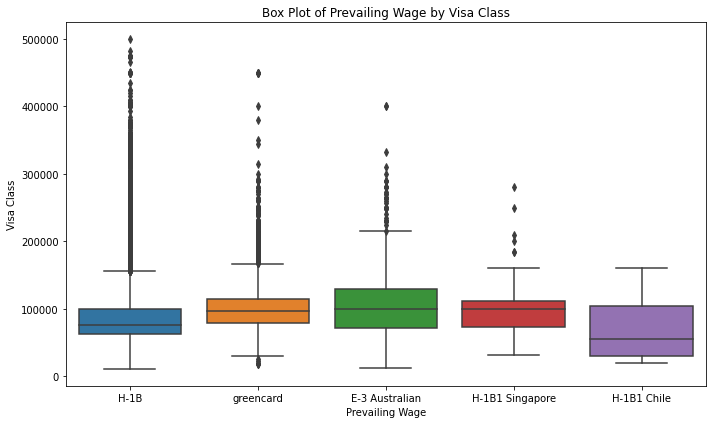

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame to exclude rows where VISA_CLASS is "Don't view"
filtered_df = spark.sql("""
    SELECT VISA_CLASS, PREVAILING_WAGE
    FROM fact_visa_cases
    WHERE VISA_CLASS <> "Don't view"
    AND PREVAILING_WAGE < 500000
""")

# Select the necessary columns for the box plot
selected_columns = ["VISA_CLASS", "PREVAILING_WAGE"]

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = filtered_df.select(selected_columns).toPandas()

# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=pandas_df, x="VISA_CLASS", y="PREVAILING_WAGE")
plt.xlabel("Prevailing Wage")
plt.ylabel("Visa Class")
plt.title("Box Plot of Prevailing Wage by Visa Class")
plt.tight_layout()
plt.show()



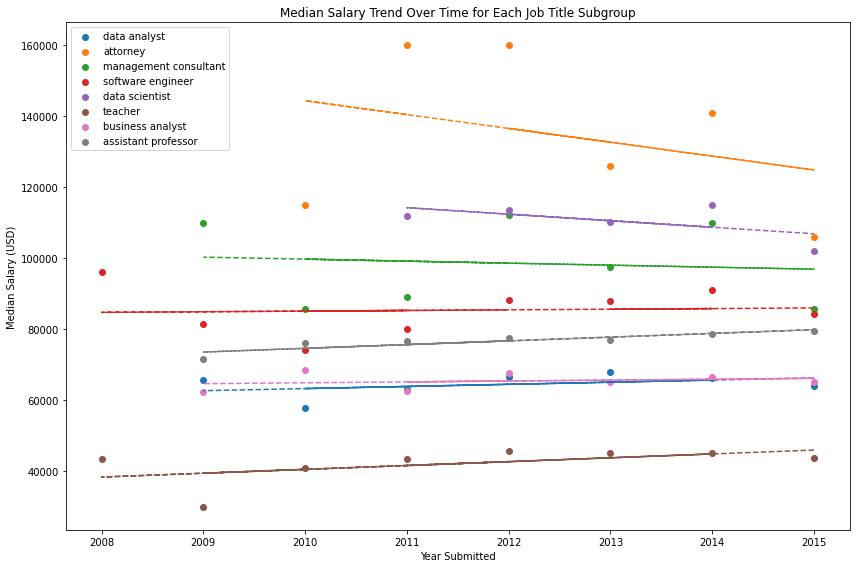

In [0]:
# Execute the SQL query to get median wages over time for each JOB_TITLE_SUBGROUP
query_result_df = spark.sql("""
    SELECT YEAR(CASE_SUBMITTED) as Year_Submitted, JOB_TITLE_SUBGROUP, MEDIAN(PREVAILING_WAGE) as median_prevailing_wage
    FROM fact_visa_cases
    WHERE VISA_CLASS <> "Don't view"
    GROUP BY 1, 2
""")

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = query_result_df.toPandas()

# Get unique job title subgroups
job_title_subgroups = pandas_df["JOB_TITLE_SUBGROUP"].unique()

# Define a color map for each subgroup
color_map = plt.get_cmap('tab10')

# Plot individual data points and trend lines for each job title subgroup
plt.figure(figsize=(12, 8))
for idx, subgroup in enumerate(job_title_subgroups):
    subgroup_data = pandas_df[pandas_df["JOB_TITLE_SUBGROUP"] == subgroup]
    color = color_map(idx)  # Get a unique color for each subgroup
    plt.scatter(subgroup_data["Year_Submitted"], subgroup_data["median_prevailing_wage"], label=subgroup, marker='o', color=color)

    # Calculate and plot trend line using numpy.polyfit for each subgroup
    trend = np.polyfit(subgroup_data["Year_Submitted"], subgroup_data["median_prevailing_wage"], 1)
    plt.plot(subgroup_data["Year_Submitted"], trend[0] * subgroup_data["Year_Submitted"] + trend[1], linestyle='dashed', color=color)

plt.xlabel("Year Submitted")
plt.ylabel("Median Salary (USD)")
plt.title("Median Salary Trend Over Time for Each Job Title Subgroup")
plt.legend()
plt.tight_layout()
plt.show()

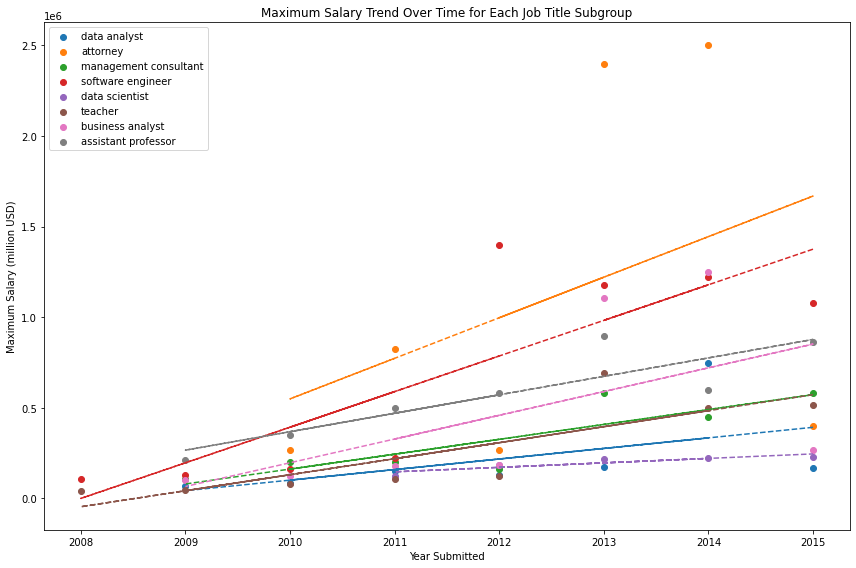

In [0]:
# Execute the SQL query to get median wages over time for each JOB_TITLE_SUBGROUP
query_result_df = spark.sql("""
    SELECT YEAR(CASE_SUBMITTED) as Year_Submitted, JOB_TITLE_SUBGROUP, MAX(PREVAILING_WAGE) as max_prevailing_wage
    FROM fact_visa_cases
    WHERE VISA_CLASS <> "Don't view"
    GROUP BY 1, 2
""")

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = query_result_df.toPandas()

# Get unique job title subgroups
job_title_subgroups = pandas_df["JOB_TITLE_SUBGROUP"].unique()

# Define a color map for each subgroup
color_map = plt.get_cmap('tab10')

# Plot individual data points and trend lines for each job title subgroup
plt.figure(figsize=(12, 8))
for idx, subgroup in enumerate(job_title_subgroups):
    subgroup_data = pandas_df[pandas_df["JOB_TITLE_SUBGROUP"] == subgroup]
    color = color_map(idx)  # Get a unique color for each subgroup
    plt.scatter(subgroup_data["Year_Submitted"], subgroup_data["max_prevailing_wage"], label=subgroup, marker='o', color=color)

    # Calculate and plot trend line using numpy.polyfit for each subgroup
    trend = np.polyfit(subgroup_data["Year_Submitted"], subgroup_data["max_prevailing_wage"], 1)
    plt.plot(subgroup_data["Year_Submitted"], trend[0] * subgroup_data["Year_Submitted"] + trend[1], linestyle='dashed', color=color)

plt.xlabel("Year Submitted")
plt.ylabel("Maximum Salary (million USD)")
plt.title("Maximum Salary Trend Over Time for Each Job Title Subgroup")
plt.legend()
plt.tight_layout()
plt.show()

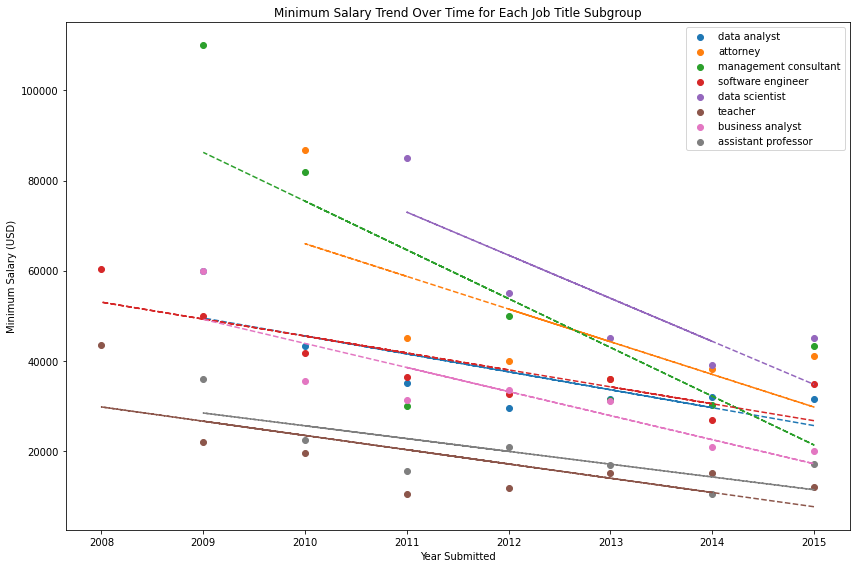

In [0]:
# Execute the SQL query to get median wages over time for each JOB_TITLE_SUBGROUP
query_result_df = spark.sql("""
    SELECT YEAR(CASE_SUBMITTED) as Year_Submitted, JOB_TITLE_SUBGROUP, MIN(PREVAILING_WAGE) as min_prevailing_wage
    FROM fact_visa_cases
    WHERE VISA_CLASS <> "Don't view"
    GROUP BY 1, 2
""")

# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = query_result_df.toPandas()

# Get unique job title subgroups
job_title_subgroups = pandas_df["JOB_TITLE_SUBGROUP"].unique()

# Define a color map for each subgroup
color_map = plt.get_cmap('tab10')

# Plot individual data points and trend lines for each job title subgroup
plt.figure(figsize=(12, 8))
for idx, subgroup in enumerate(job_title_subgroups):
    subgroup_data = pandas_df[pandas_df["JOB_TITLE_SUBGROUP"] == subgroup]
    color = color_map(idx)  # Get a unique color for each subgroup
    plt.scatter(subgroup_data["Year_Submitted"], subgroup_data["min_prevailing_wage"], label=subgroup, marker='o', color=color)

    # Calculate and plot trend line using numpy.polyfit for each subgroup
    trend = np.polyfit(subgroup_data["Year_Submitted"], subgroup_data["min_prevailing_wage"], 1)
    plt.plot(subgroup_data["Year_Submitted"], trend[0] * subgroup_data["Year_Submitted"] + trend[1], linestyle='dashed', color=color)

plt.xlabel("Year Submitted")
plt.ylabel("Minimum Salary (USD)")
plt.title("Minimum Salary Trend Over Time for Each Job Title Subgroup")
plt.legend()
plt.tight_layout()
plt.show()